In [1]:
import os
os.chdir('/mnt/d/자료/대회/KAMP 2024')

import pandas as pd
import numpy as np

In [2]:
# data_path = r'./data/raw_dataset.csv'
data_path = r'./data/raw_dataset_temp_humid.csv'

aa = pd.read_csv(data_path, encoding='cp949', index_col=0)

/tmp/ipykernel_2133/3360083120.py:4: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  aa = pd.read_csv(data_path, encoding='cp949', index_col=0)


In [3]:
def time_process(df):
    # df['year'] = df['registration_time'].dt.year
    # df['month'] = df['registration_time'].dt.month
    # df['day'] = df['registration_time'].dt.day
    # df['hour'] = df['registration_time'].dt.hour
    # df['minute'] = df['registration_time'].dt.minute
    df['week_day'] = df['registration_time'].dt.weekday

# def remove_outliers(df, quant):
#     dataset = df.copy()
#     standard = quant/2
#     for col in dataset.columns:
#         if col=='passorfail' or col=='registration_time' or col=='working' or col=='tryshot_signal':
#             pass
#         else:
#             lower_limit = dataset[col].quantile(standard/100)
#             upper_limit = dataset[col].quantile(1-standard/100)
#             dataset = dataset[(dataset[col]>=lower_limit) & (dataset[col]<=upper_limit)]

#     return dataset

def remove_outliers(df):
    dataset = df.copy()
    conditions = [
        ('low_section_speed', 2000),
        ('upper_mold_temp1', 1000),
        ('upper_mold_temp2', 1000),
        ('lower_mold_temp2', 1000),
        ('lower_mold_temp3', 1500),
        ('physical_strength', 2000),
        ('Coolant_temperature', 1000)
    ]

    # 조건에 따라 이상치 값 대체
    for column, threshold in conditions:
        # 이상치가 아닌 값들의 평균 계산
        mean_value = dataset[dataset[column] <= threshold][column].mean()
        # 이상치 값을 평균으로 대체
        dataset.loc[dataset[column] > threshold, column] = mean_value

    return dataset

def add_gas_volume(df):
    # V = nRT/P
    # Ideal Gas Equation

    output = df.copy()
    output['gas_volume'] = output['molten_temp'] / (output['cast_pressure'] + 1e-5)

    return output

def add_vapor_pressure(df):
    # Antoine Equation
    output = df.copy()
    output['vapor_pressure'] = np.exp(-1/(output['molten_temp']))
    return output

def add_kinetics(df):
    # Antoine Equation
    output = df.copy()
    output['kinetics'] = np.exp(-1/(output['molten_temp'])) * output['production_cycletime']
    return output

def add_temp_gradient_sleeve(df):
    output = df.copy()
    output['temp_gradient_sleeve'] = output['molten_temp'] - output['sleeve_temperature']
    return output
    
def add_temp_gradient_outside(df):
    output = df.copy()
    output['temp_gradient_outside'] = output['molten_temp'] - output['out_temp']
    return output

def add_temp_gradient_coolant(df):
    output = df.copy()
    output['temp_gradient_coolant'] = output['molten_temp'] - output['Coolant_temperature']
    return output   



In [4]:
print(aa.shape, '\n')

df = aa[[col for col in aa.columns if len(aa[col].unique())!=1]]

print(len(df['working'].unique()))

print('Removed')
print([col for col in aa.columns if col not in df.columns], '\n')


df_new_columns = [col for col in df.columns if col not in  ['time', 'date', 'heating_furnace' , 'count', 'emergency_stop', 'molten_volume']]

df = df[df_new_columns]

df['tryshot_signal'] = df['tryshot_signal'].fillna(0)

df = df[[col for col in df.columns if col not in ['EMS_operation_time', 'mold_code', 'facility_operation_cycleTime']]]

df.dropna(inplace=True)

df = remove_outliers(df)

df = add_gas_volume(df)

df = add_vapor_pressure(df)

df = add_kinetics(df)

df = add_temp_gradient_sleeve(df)

df = add_temp_gradient_outside(df)

df = add_temp_gradient_coolant(df)

df['registration_time'] = pd.to_datetime(df['registration_time'])
time_process(df)

df.set_index(keys='registration_time', inplace=True)
df.sort_index(ascending=True, inplace=True)


(92015, 33) 

3
Removed
['line', 'name', 'mold_name'] 



In [5]:
input_categorical = pd.get_dummies(df[['week_day', 'working', 'tryshot_signal']], columns=['week_day', 'working', 'tryshot_signal'], dtype='int')

input_numerical = df[[col for col in df.columns if col not in ['week_day', 'passorfail', 'working', 'tryshot_signal']]]

label = df['passorfail']

In [6]:
input_categorical

,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,working_가동,working_정지,tryshot_signal_0,tryshot_signal_D
registration_time,,,,,,,,,,,
2019-01-02 16:45:06,0,0,1,0,0,0,0,1,0,1,0
2019-01-02 17:27:28,0,0,1,0,0,0,0,1,0,1,0
2019-01-02 17:29:32,0,0,1,0,0,0,0,1,0,1,0
2019-01-02 17:31:41,0,0,1,0,0,0,0,1,0,1,0
2019-01-02 17:33:39,0,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 23:51:29,0,0,0,0,0,0,1,1,0,1,0
2019-03-31 23:53:28,0,0,0,0,0,0,1,1,0,1,0
2019-03-31 23:55:44,0,0,0,0,0,0,1,1,0,1,0


In [7]:
from sklearn.model_selection import train_test_split

train_categorical, test_categorical, train_numerical, test_numerical, train_label, test_label = train_test_split(input_categorical, input_numerical, label, test_size=0.1, shuffle=True, random_state=25)
train_categorical, val_categorical, train_numerical, val_numerical, train_label, val_label = train_test_split(train_categorical, train_numerical, train_label, test_size=0.1, shuffle=True, random_state=25)

print(train_categorical.shape)
print(val_categorical.shape)
print(test_categorical.shape)
print()

print(train_numerical.shape)
print(val_numerical.shape)
print(test_numerical.shape)
print()

print(train_label.shape)
print(val_label.shape)
print(test_label.shape)
print()

(72446, 11)
(8050, 11)
(8945, 11)

(72446, 23)
(8050, 23)
(8945, 23)

(72446,)
(8050,)
(8945,)



In [8]:
train_numerical.columns

Index(['molten_temp', 'production_cycletime', 'low_section_speed',
       'high_section_speed', 'cast_pressure', 'biscuit_thickness',
       'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3',
       'lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3',
       'sleeve_temperature', 'physical_strength', 'Coolant_temperature',
       'out_temp', 'out_humid', 'gas_volume', 'vapor_pressure', 'kinetics',
       'temp_gradient_sleeve', 'temp_gradient_outside',
       'temp_gradient_coolant'],
      dtype='object')

In [9]:
# import pickle
# os.makedirs('./data/dataset/', exist_ok=True)

# with open('./data/dataset/train_numerical.pkl', 'wb') as file:
#     pickle.dump(train_numerical, file)

# with open('./data/dataset/val_numerical.pkl', 'wb') as file:
#     pickle.dump(val_numerical, file)

# with open('./data/dataset/test_numerical.pkl', 'wb') as file:
#     pickle.dump(test_numerical, file)

# with open('./data/dataset/train_categorical.pkl', 'wb') as file:
#     pickle.dump(train_categorical, file)

# with open('./data/dataset/val_categorical.pkl', 'wb') as file:
#     pickle.dump(val_categorical, file)

# with open('./data/dataset/test_categorical.pkl', 'wb') as file:
#     pickle.dump(test_categorical, file)

# with open('./data/dataset/train_label.pkl', 'wb') as file:
#     pickle.dump(train_label, file)

# with open('./data/dataset/val_label.pkl', 'wb') as file:
#     pickle.dump(val_label, file)

# with open('./data/dataset/test_label.pkl', 'wb') as file:
#     pickle.dump(test_label, file)

In [10]:
for col in train_categorical.columns:
    print(col)

week_day_0
week_day_1
week_day_2
week_day_3
week_day_4
week_day_5
week_day_6
working_가동
working_정지
tryshot_signal_0
tryshot_signal_D


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from xgboost.callback import EvaluationMonitor
import pickle
import optuna
from optuna.integration import XGBoostPruningCallback


class optimize():
    def __init__(self,
    train_numerical,
    train_categorical,
    train_label,
    val_numerical,
    val_categorical,
    val_label,
    test_numerical,
    test_categorical,
    test_label,
    ):

        self.train_numerical = train_numerical.reset_index(drop=True)
        self.train_categorical = train_categorical.reset_index(drop=True)
        self.train_label = train_label.reset_index(drop=True)

        self.val_numerical = val_numerical.reset_index(drop=True)
        self.val_categorical = val_categorical.reset_index(drop=True)
        self.val_label = val_label.reset_index(drop=True)

        self.test_numerical = test_numerical.reset_index(drop=True)
        self.test_categorical = test_categorical.reset_index(drop=True)
        self.test_label = test_label.reset_index(drop=True)

        self.best_score = 0
        self.scaler = None

        os.makedirs('./model/', exist_ok=True)

    def objective(self, trial):
        max_depth = trial.suggest_int('max_depth', 3, 100)
        eta = trial.suggest_loguniform('eta', 1e-3, 1)
        sampler_key = trial.suggest_categorical('sampler', ['ADASYN','SMOTE', 'RandomUnderSampler', 'RandomOverSampler','BorderlineSMOTE','SVMSMOTE', 'None'])
        gamma = trial.suggest_float('gamma', 0, 3)
        lam = trial.suggest_float('L2_weight', 0, 1)
        alpha = trial.suggest_float('L1_weight', 0, 1)
        threshold = trial.suggest_float('threshold', 0.2, 0.8)
        scaler_key = trial.suggest_categorical('scaler', ['MinMaxScaler', 'StandardScaler','RobustScaler', 'None'])

        sampler_dict = {
            'ADASYN':ADASYN(random_state=25),
            'SMOTE':SMOTE(random_state=25),
            'RandomUnderSampler':RandomUnderSampler(random_state=25),
            'RandomOverSampler':RandomOverSampler(random_state=25),
            'BorderlineSMOTE':BorderlineSMOTE(random_state=25),
            'SVMSMOTE':SVMSMOTE(random_state=25),
        }

        scaler_dict = {
            'MinMaxScaler':MinMaxScaler(),
            'StandardScaler':StandardScaler(),
            'RobustScaler':RobustScaler(),
        }

        y_train = self.train_label

        if scaler_key == 'None':
            x_train = pd.concat([self.train_numerical, self.train_categorical], axis=1)
            x_val = pd.concat([self.val_numerical, self.val_categorical], axis=1)
            x_test = pd.concat([self.test_numerical, self.test_categorical], axis=1)

            scaler = None

        else:
            scaler = scaler_dict[scaler_key]
            train_numerical = pd.DataFrame(scaler.fit_transform(self.train_numerical), columns=self.train_numerical.columns)
            val_numerical = pd.DataFrame(scaler.transform(self.val_numerical), columns=self.train_numerical.columns)
            test_numerical = pd.DataFrame(scaler.transform(self.test_numerical), columns=self.train_numerical.columns)

            x_train = pd.concat([train_numerical, self.train_categorical], axis=1)
            x_val = pd.concat([val_numerical, self.val_categorical], axis=1)
            x_test = pd.concat([test_numerical, self.test_categorical], axis=1)


        if sampler_key == 'None':
            x_resampled, y_resampled = x_train, y_train

        else:
            sampler = sampler_dict[sampler_key]
            x_resampled, y_resampled = sampler.fit_resample(x_train, y_train)



        param = {
            'eta': eta,
            'max_depth':max_depth, 
            'objective': 'binary:logistic',
            'eval_metric':['logloss'],
            'device':'gpu',
            'tree_method':'gpu_hist',
            'predictor':'gpu_predictor',
            'lambda':lam,
            'alpha':alpha,
            'gamma':gamma,
            'random_state':25,
            }

        # print(param)

        dtrain = xgb.DMatrix(data=x_resampled, label=y_resampled)
        dval = xgb.DMatrix(data=x_val, label=self.val_label)
        dtest = xgb.DMatrix(data=x_test)

        eval_list = [(dval, 'val')]

        bst = xgb.train(param, dtrain, num_boost_round=50000, evals=eval_list, early_stopping_rounds=100, callbacks=[XGBoostPruningCallback(trial, 'val-logloss')])

        y_prob = bst.predict(dtest)
        y_pred = (y_prob>=threshold).astype(int)

        f1 = f1_score(self.test_label, y_pred)

        self.best_score = max(f1, self.best_score)

        if self.best_score == f1:
            bst.save_model(f"./model/best_model_{f1:.4f}.json")

            self.scaler = scaler

        return f1


    def optimize(self, study_name='KAMP2024', direction='maximize', storage='sqlite:////mnt/d/OPTIMIZE_XGB.db', load_if_exists=True, n_trials=1000):
        study = optuna.create_study(
            study_name = study_name,
            direction = direction,
            storage = storage,
            load_if_exists = load_if_exists
        )

        study.optimize(self.objective, n_trials=n_trials)

/root/anaconda3/envs/DeepLearning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
optimizer = optimize(
    train_numerical,
    train_categorical,
    train_label,
    val_numerical,
    val_categorical,
    val_label,
    test_numerical,
    test_categorical,
    test_label,
)

In [13]:
# optimizer.optimize()

In [47]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix

best_model = xgb.Booster()
best_model.load_model('./model/best_model_0.9724.json')

train_numerical = train_numerical.reset_index(drop=True)
train_categorical = train_categorical.reset_index(drop=True)
train_label = train_label.reset_index(drop=True)

val_numerical = val_numerical.reset_index(drop=True)
val_categorical = val_categorical.reset_index(drop=True)
val_label = val_label.reset_index(drop=True)

test_numerical = test_numerical.reset_index(drop=True)
test_categorical = test_categorical.reset_index(drop=True)
test_label = test_label.reset_index(drop=True)


scaler = RobustScaler()

train_numerical = pd.DataFrame(scaler.fit_transform(train_numerical), columns=train_numerical.columns)
val_numerical = pd.DataFrame(scaler.transform(val_numerical), columns=train_numerical.columns)
test_numerical = pd.DataFrame(scaler.transform(test_numerical), columns=train_numerical.columns)

x_train = pd.concat([train_numerical, train_categorical], axis=1)
x_val = pd.concat([val_numerical, val_categorical], axis=1)
x_test = pd.concat([test_numerical, test_categorical], axis=1)

dtest = xgb.DMatrix(data=x_test)

threshold = 0.45740842223435063

y_prob = best_model.predict(dtest)
y_pred = (y_prob>=threshold).astype(int)

f1 = f1_score(test_label, y_pred)
precision = precision_score(test_label, y_pred)
recall = recall_score(test_label, y_pred)
accuracy = accuracy_score(test_label, y_pred)

print('f1', f1)
print('precision', precision)
print('recall', recall)
print('accuracy', accuracy)

f1 0.9723889555822329
precision 0.9688995215311005
recall 0.9759036144578314
accuracy 0.9974287311347121


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

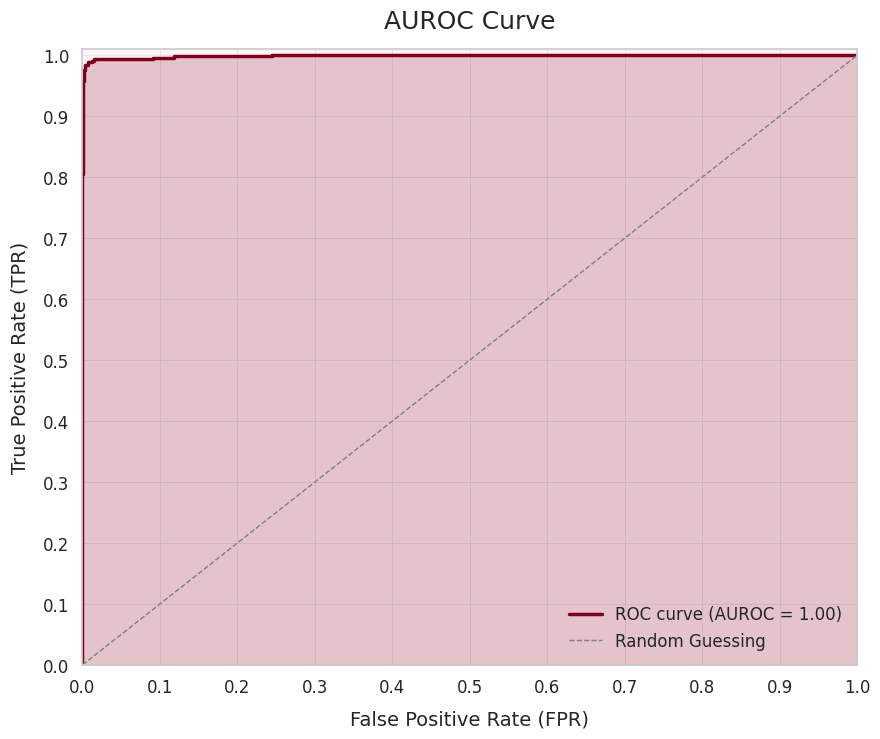

In [31]:
fpr, tpr, thresholds = roc_curve(test_label, y_prob)
auroc_score = auc(fpr, tpr)

plt.figure(figsize=(10, 8))

# ROC 곡선 플롯 (버건디 계열 색상)
plt.plot(fpr, tpr, color='#800020', lw=2.5, label=f'ROC curve (AUROC = {auroc_score:.2f})')

# ROC 곡선 아래 영역 채우기 (버건디 계열 색상, 투명도 조정)
plt.fill_between(fpr, tpr, color='#800020', alpha=0.2)

# 랜덤 추측 라인
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guessing')

# 레이블 및 제목 추가
plt.xlabel('False Positive Rate (FPR)', fontsize=14, labelpad=10)
plt.ylabel('True Positive Rate (TPR)', fontsize=14, labelpad=10)
plt.title('AUROC Curve', fontsize=18, pad=15)

# 격자 설정
plt.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.7)

# 축 범위 및 눈금 설정
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xticks(np.arange(0, 1.1, step=0.1), fontsize=12)
plt.yticks(np.arange(0, 1.1, step=0.1), fontsize=12)

# 배경 색상 조정
plt.gca().set_facecolor('#FDF5F5')  # 연한 핑크 톤 배경으로 버건디와 어울리게 설정

# 범례 설정
plt.legend(loc="lower right", fontsize=12, frameon=False)

# 그래프 표시
plt.show()

In [48]:
# Confusion Matrix
test_conf_matrix = confusion_matrix(test_label, y_pred)
print(f"Confusion Matrix:\n{test_conf_matrix}")

Confusion Matrix:
[[8517   13]
 [  10  405]]


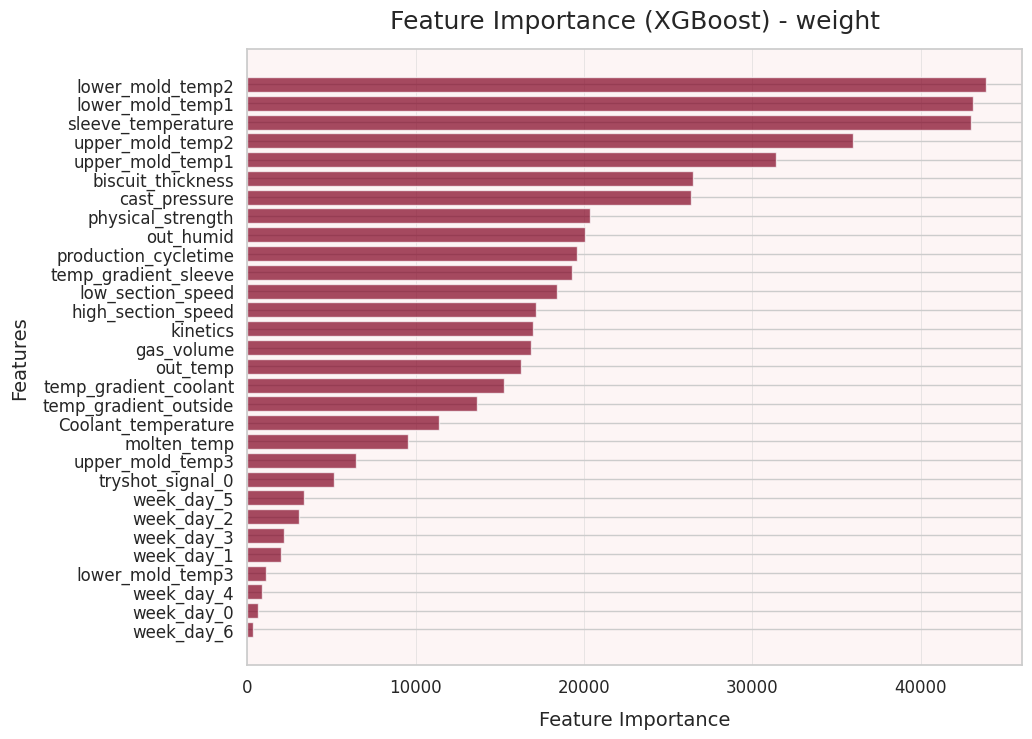

In [40]:
metric = 'weight'

importance = best_model.get_score(importance_type=metric)
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

features = [item[0] for item in importance]
values = [item[1] for item in importance]

# 그래프 설정
plt.figure(figsize=(10, 8))
plt.barh(features, values, color='#800020', alpha=0.7)

# 레이블 및 제목 추가
plt.xlabel('Feature Importance', fontsize=14, labelpad=10)
plt.ylabel('Features', fontsize=14, labelpad=10)
plt.title(f"Feature Importance (XGBoost) - {metric}", fontsize=18, pad=15)

# 격자 설정 (가로선만 표시)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5, axis='x', alpha=0.7)

# 배경 색상 조정
plt.gca().set_facecolor('#FDF5F5')  # 연한 핑크 톤 배경으로 버건디와 조화롭게 설정

# 눈금 및 폰트 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그래프 표시
plt.gca().invert_yaxis()  # 중요도가 높은 특성이 위쪽에 오도록 반전
plt.show()

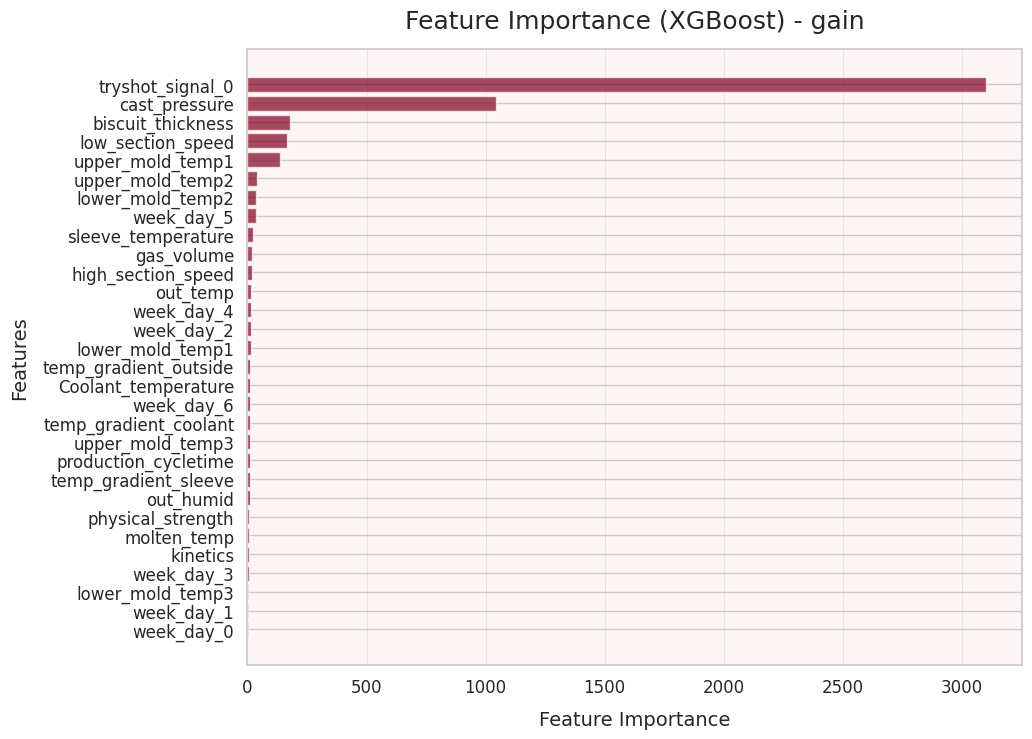

In [41]:
metric = 'gain'

importance = best_model.get_score(importance_type=metric)
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

features = [item[0] for item in importance]
values = [item[1] for item in importance]

# 그래프 설정
plt.figure(figsize=(10, 8))
plt.barh(features, values, color='#800020', alpha=0.7)

# 레이블 및 제목 추가
plt.xlabel('Feature Importance', fontsize=14, labelpad=10)
plt.ylabel('Features', fontsize=14, labelpad=10)
plt.title(f"Feature Importance (XGBoost) - {metric}", fontsize=18, pad=15)

# 격자 설정 (가로선만 표시)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5, axis='x', alpha=0.7)

# 배경 색상 조정
plt.gca().set_facecolor('#FDF5F5')  # 연한 핑크 톤 배경으로 버건디와 조화롭게 설정

# 눈금 및 폰트 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그래프 표시
plt.gca().invert_yaxis()  # 중요도가 높은 특성이 위쪽에 오도록 반전
plt.show()

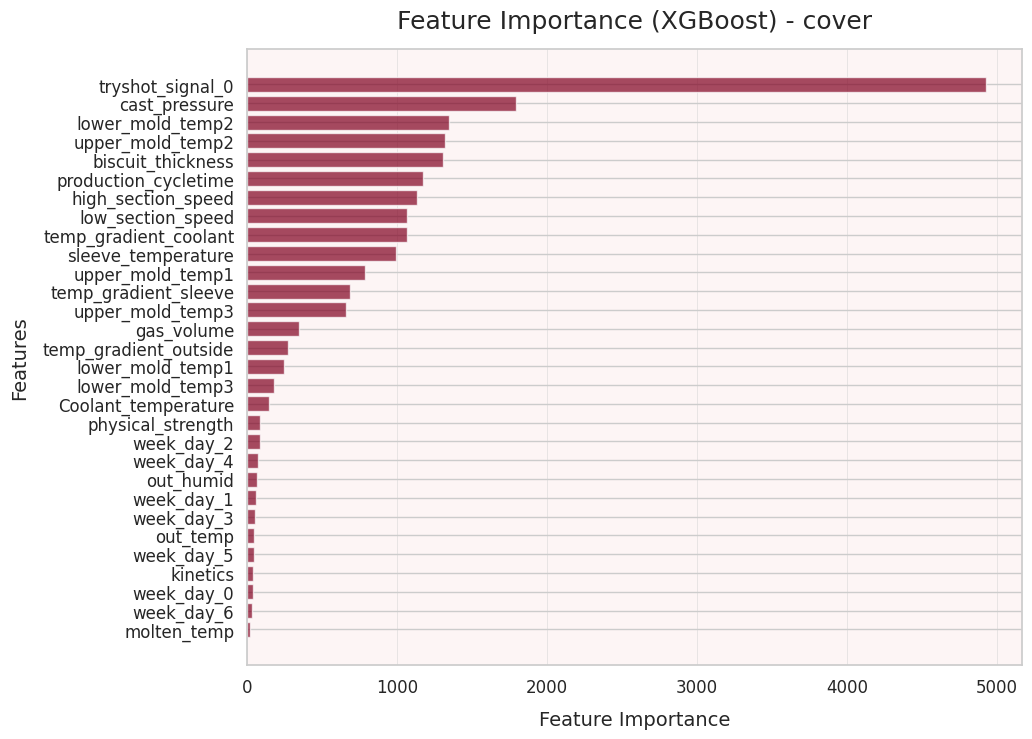

In [42]:
metric = 'cover'

importance = best_model.get_score(importance_type=metric)
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

features = [item[0] for item in importance]
values = [item[1] for item in importance]

# 그래프 설정
plt.figure(figsize=(10, 8))
plt.barh(features, values, color='#800020', alpha=0.7)

# 레이블 및 제목 추가
plt.xlabel('Feature Importance', fontsize=14, labelpad=10)
plt.ylabel('Features', fontsize=14, labelpad=10)
plt.title(f"Feature Importance (XGBoost) - {metric}", fontsize=18, pad=15)

# 격자 설정 (가로선만 표시)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5, axis='x', alpha=0.7)

# 배경 색상 조정
plt.gca().set_facecolor('#FDF5F5')  # 연한 핑크 톤 배경으로 버건디와 조화롭게 설정

# 눈금 및 폰트 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그래프 표시
plt.gca().invert_yaxis()  # 중요도가 높은 특성이 위쪽에 오도록 반전
plt.show()

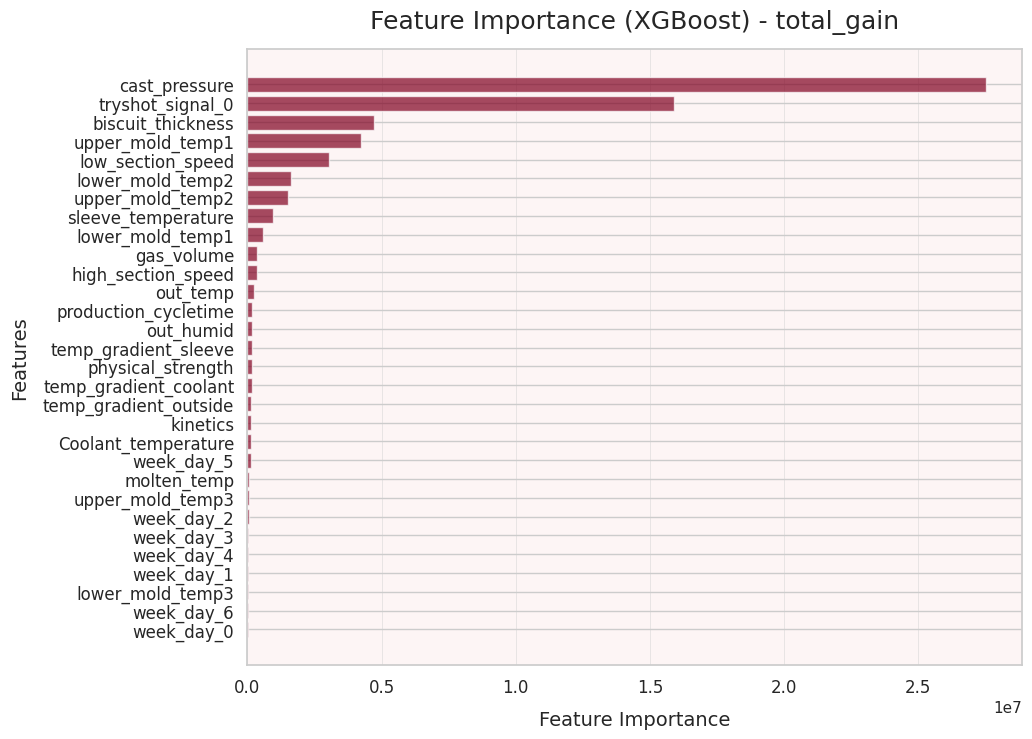

In [43]:
metric = 'total_gain'

importance = best_model.get_score(importance_type=metric)
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

features = [item[0] for item in importance]
values = [item[1] for item in importance]

# 그래프 설정
plt.figure(figsize=(10, 8))
plt.barh(features, values, color='#800020', alpha=0.7)

# 레이블 및 제목 추가
plt.xlabel('Feature Importance', fontsize=14, labelpad=10)
plt.ylabel('Features', fontsize=14, labelpad=10)
plt.title(f"Feature Importance (XGBoost) - {metric}", fontsize=18, pad=15)

# 격자 설정 (가로선만 표시)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5, axis='x', alpha=0.7)

# 배경 색상 조정
plt.gca().set_facecolor('#FDF5F5')  # 연한 핑크 톤 배경으로 버건디와 조화롭게 설정

# 눈금 및 폰트 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그래프 표시
plt.gca().invert_yaxis()  # 중요도가 높은 특성이 위쪽에 오도록 반전
plt.show()

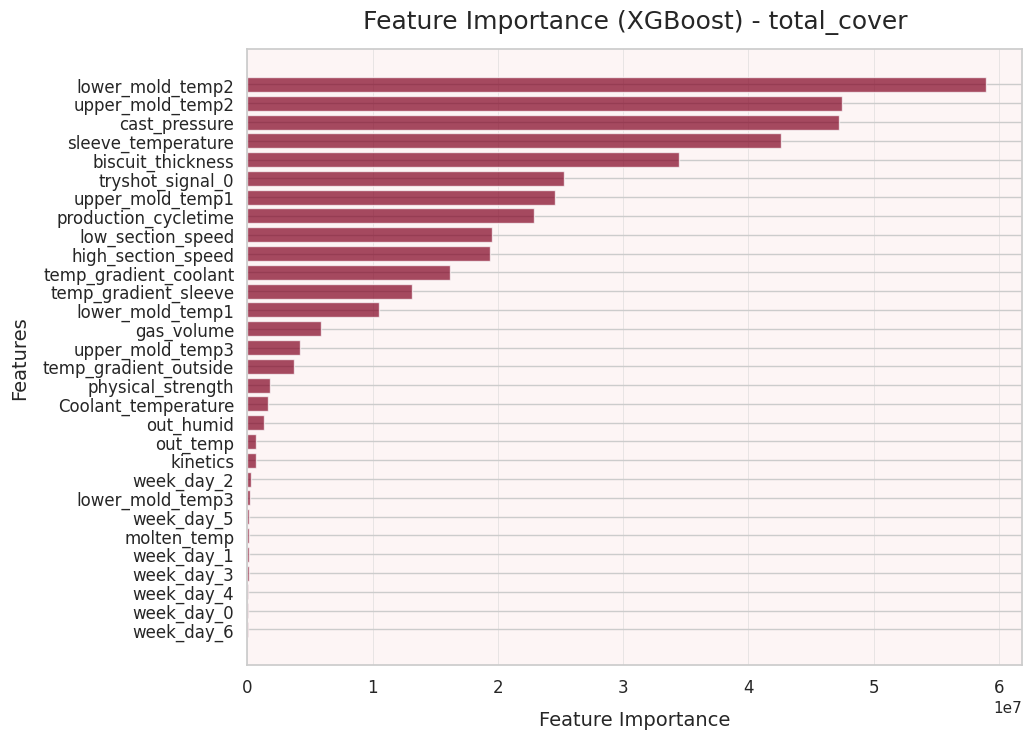

In [44]:
metric = 'total_cover'

importance = best_model.get_score(importance_type=metric)
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

features = [item[0] for item in importance]
values = [item[1] for item in importance]

# 그래프 설정
plt.figure(figsize=(10, 8))
plt.barh(features, values, color='#800020', alpha=0.7)

# 레이블 및 제목 추가
plt.xlabel('Feature Importance', fontsize=14, labelpad=10)
plt.ylabel('Features', fontsize=14, labelpad=10)
plt.title(f"Feature Importance (XGBoost) - {metric}", fontsize=18, pad=15)

# 격자 설정 (가로선만 표시)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5, axis='x', alpha=0.7)

# 배경 색상 조정
plt.gca().set_facecolor('#FDF5F5')  # 연한 핑크 톤 배경으로 버건디와 조화롭게 설정

# 눈금 및 폰트 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그래프 표시
plt.gca().invert_yaxis()  # 중요도가 높은 특성이 위쪽에 오도록 반전
plt.show()

In [45]:
importance

[('lower_mold_temp2', 58948148.0),
 ('upper_mold_temp2', 47498268.0),
 ('cast_pressure', 47242060.0),
 ('sleeve_temperature', 42614732.0),
 ('biscuit_thickness', 34458684.0),
 ('tryshot_signal_0', 25270516.0),
 ('upper_mold_temp1', 24590152.0),
 ('production_cycletime', 22890104.0),
 ('low_section_speed', 19561566.0),
 ('high_section_speed', 19397616.0),
 ('temp_gradient_coolant', 16171573.0),
 ('temp_gradient_sleeve', 13140057.0),
 ('lower_mold_temp1', 10535459.0),
 ('gas_volume', 5847286.5),
 ('upper_mold_temp3', 4231218.5),
 ('temp_gradient_outside', 3724622.0),
 ('physical_strength', 1771618.5),
 ('Coolant_temperature', 1603087.5),
 ('out_humid', 1309008.875),
 ('out_temp', 720086.375),
 ('kinetics', 643375.0625),
 ('week_day_2', 267097.84375),
 ('lower_mold_temp3', 192913.6875),
 ('week_day_5', 143892.859375),
 ('molten_temp', 131804.90625),
 ('week_day_1', 115841.3515625),
 ('week_day_3', 109002.03125),
 ('week_day_4', 60082.703125),
 ('week_day_0', 20410.724609375),
 ('week_day_